### Initialize libraries

In [179]:
%matplotlib inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

### Initialize Model Constants

In [180]:
RJupiter = 6.99e9    # cm

gamma = 2
G = 6.67e-8    # dyne*cm^2/g^2

rhoC = 5    # g/cm^3, central density
PC = 6.5e13    # dyne/cm^2
TC = 22000    # K

K = 2.6e12    # dyne*cm^4/g^2

alpha = np.sqrt(K/(2*np.pi*G))

h = 1e9      # h of 4e8 returns a mass on the same order of true mass of Jupiter

### Initialize Radial Position of Planets

In [181]:
N1 = 1000        # Particles in planet 1

# Use partition to give initial radial positions of particles
partitionNum = 5     
rSpace = np.linspace(0, RJupiter, partitionNum)
zetaSpace = rSpace/alpha

# Establish number of particles in each region of delta(zeta)
NDistribution = []    
for i in range(1,len(zetaSpace)):
    zeta2 = zetaSpace[i]
    zeta1 = zetaSpace[i-1]
    NDistribution.append((np.sin(zeta2) - zeta2*np.cos(zeta2) - np.sin(zeta1) + zeta1*np.cos(zeta1))\
                         *N1/np.pi)
    
NDistribution = np.array(NDistribution)
NDistribution = np.round(NDistribution)

# Create radial distribution
radiusDistribution = []
i = 0
for N in NDistribution:
    radiusDistribution.append(np.random.uniform(rSpace[i], rSpace[i+1], size=N))
    i += 1
    
# Flatten radial array
radiusDistribution = [item for sublist in radiusDistribution for item in sublist]
radiusDistribution = np.array(radiusDistribution)

# Create angle distribution
thetaDistribution = np.random.uniform(0, 2*np.pi, size=len(radiusDistribution))

c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Initialize Cartesian Position of Planets

In [182]:
def polar2cart(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)]).T

xyDistribution = polar2cart(radiusDistribution, thetaDistribution)
nParticles = len(xyDistribution)

### Model Initial Density & Pressure Distribution

In [183]:
rhoDistribution = rhoC * np.sin(radiusDistribution/alpha) / (radiusDistribution/alpha)

pressureDistribution = K * rhoDistribution ** gamma

### Define Gradient for special case of mass initialization

In [184]:
# MJupiter = 1.89e30    # grams

def mW(xyDistribution, h= 7e9, verbose=False):
    '''
    h = ~3e9 looks like a good range
    Finding W for all pairs (i,j), instead of just j. 
    I'm flattening W at the end of the function. I might be meant to flatten W
        by flattening the |r-rj| by taking their sum
    '''
        
    distVect = np.zeros((len(xyDistribution), len(xyDistribution)))
                  
    # Find distance between each j and the other points
    for i in range(len(xyDistribution)):
        particle_i = xyDistribution[i]
        dist = np.sqrt((particle_i[0] - xyDistribution[:,0])**2 + (particle_i[1] - xyDistribution[:,1])**2)
        # Store distances in a matrix
        distVect[:,i] = dist
    
    # r < 1
    distVect1 = distVect < h
    distVect1 = distVect1.astype(int)
    if verbose:
        print "Percent of molecules within 1 smoothing length:", \
            np.count_nonzero(distVect1) / (len(xyDistribution)**2)
            
    # Matrix containing radii (where only nonzero values are radii < h)
    R1 = distVect1 * distVect   
    W1 = distVect1 / (np.pi * h**3) * (1 - 3/2*(R1/h)**2 + 3/4*(R1/h)**3)
    
    if np.min(W1) < 0:
        print "Warning! Negative smoothing kernel detected!"

    # r > 2h
    distVect2 = distVect > 2 * h
    distVect2 = distVect2.astype(int)
    if verbose:
        print "Percent of molecules which do not affect the particle:", \
            np.count_nonzero(distVect2) / (len(xyDistribution)**2)
    
    # h < r < 2h
    distVect12 = np.logical_not(np.logical_or(distVect1, distVect2))
    if verbose:
        print "Percent of molecules within 2 smoothing lengths:", \
                np.count_nonzero(distVect12) / (len(xyDistribution)**2)
            
    R12 = distVect12 * distVect 
    W12 = distVect12 / (4 * np.pi * h**3) * (2 - (R12/h))**3
    
    if np.min(W12) < 0:
        print "Warning! Negative smoothing kernel detected!"

    W = W1 + W12
    W = np.sum(W, axis=1)
    
    print np.count_nonzero(W)#, np.count_nonzero(distVect)
    return W

### Initialize Mass of Each Particle

In [185]:
t0 = time.time()
mDistribution = rhoDistribution/mW(xyDistribution)

## --- Old code: Made 1 particle super massive --- ###
# mDistribution = np.empty_like(rhoDistribution)
# for i in range(len(mDistribution)):
#     mDistribution[i] = rhoDistribution[i]/W(0, h)
#     for j in range(len(mDistribution)):
#         dist = np.sqrt((xyDistribution[i,0] - xyDistribution[j,0])**2 + \
#                        (xyDistribution[i,1] - xyDistribution[j,1])**2 )
#         if W(dist,h) != 0:
#             mDistribution[i] += rhoDistribution[j]/W(dist,h)
#         if i == 1:
#             if j%50 ==0:
#                 print mDistribution[i]
#     print mDistribution[i]

948


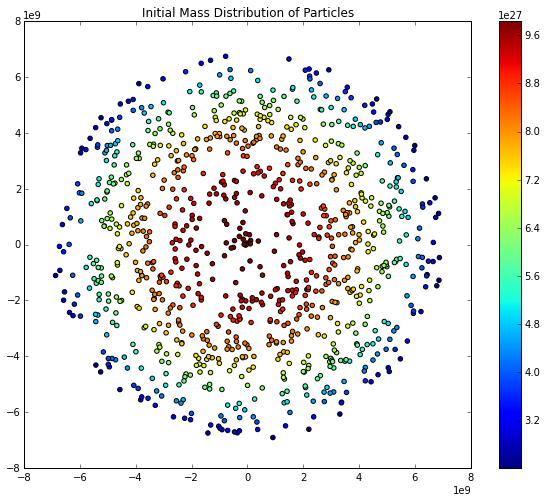

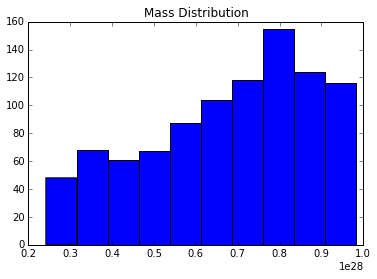

In [186]:
plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution), c=mDistribution)
plt.title("Initial Mass Distribution of Particles")
plt.colorbar()
plt.show()

plt.figure()
plt.hist(mDistribution)
plt.title("Mass Distribution")
plt.show()

### Smoothing function

In [187]:
def W(dist, h):
    '''
    Inputs:
        dist: a scalar distance between particles i an j
        h: smoothing length
    '''
    if dist < h:
        return 10/(7*np.pi*h**2) * \
               (1/4*(2-dist/h)**3 - (1-dist/h)**3)
    elif dist > 2 * h:
        return 0
    else:
        return 10/(7*np.pi*h**2) * (1/4*(2-dist/h)**3)

In [188]:
def gradW(xyDist, h):
    '''
    Inputs:
        xyDist: a [2,1] array containing the difference in [x,y] position
            between two particles
        h: smoothing length
    Outputs:
        a [2,1] array containing the [x,y] component of gradW
    '''
    
    dist = np.sqrt(xyDist[0]**2 + xyDist[1]**2)
    
    if dist < h:
        return np.array(
              [15*xyDist[0]*(3*dist - 4*h)/(14 * np.pi * h**5),
               15*xyDist[1]*(3*dist - 4*h)/(14 * np.pi * h**5)])
    
    elif dist > 2 * h:
        return np.array([0,0])
    
    else:
        return np.array(
                [-15*xyDist[0]*(2*h - dist)**2/(14*h**5*np.pi*dist),
                 -15*xyDist[1]*(2*h - dist)**2/(14*h**5*np.pi*dist)] )

In [189]:
def densityUpdate():
    
    global xyDistribution
    global rhoDistribution
    global massDistribution

    for i in range(0, nParticles):
        rhodistribution[i] = massDistribution[i]*W(0, h)

        for j in range(i, nParticles):
            if (j!=i):
                xdist = (xyDistribution[j,0]-xyDistribution[k,0])
                ydist = (xyDistribution[j,1]-xyDistribution[k,1])
            dist_ij = sqrt(xdist**2 + ydist**2)
            rho_ij = m*W(dist_ij, h)
            rhoDistribution[i] += rho_ij

In [190]:
print gradW(np.array([0,0]), 1e9).shape

(2L,)


In [191]:
print